# Factor Analysis

Factor analysis assumes that the observed variables are caused by a smaller number of unobserved (latent) factors and tries to explain why variables are correlated.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide30.png)

# Key Formula

The fundamental factor analysis model:

$$
\mathbf{X} = \mathbf{LF} + \mathbf{E}
$$

where:
- $\mathbf{X}$ is a $p \times n$ matrix of observed variables
- $\mathbf{L}$ is a $p \times k$ matrix of **factor loadings** (how strongly each variable relates to each factor)
- $\mathbf{F}$ is a $k \times n$ matrix of **factor scores** (factor values for each observation)
- $\mathbf{E}$ is a $p \times n$ matrix of **unique errors** (measurement noise specific to each variable)
- $k < p$ is the number of latent factors

# Technical Details


## Factor Rotation

For any invertible matrix $\mathbf{T}$ (often called **rotation matrix**):
$$
\mathbf{X} = \mathbf{LF} + \mathbf{E} = (\mathbf{LT})(\mathbf{T}^{-1}\mathbf{F}) + \mathbf{E}
$$

**Result:** Infinitely many $(\mathbf{L}, \mathbf{F})$ pairs fit the data equally well!

- **Without rotation**, the algorithm must impose **arbitrary constraints** just to compute something. 
- **With rotation**, a criterion is chosen to move arbitrary constraints and choose orientation based on **interpretability** to maximize "simple structure" (e.g., Varimax)
  - Each variable loads high on few factors
  - Each variable loads near zero on others
  - Factors become interpretable


## Common Constraints

The estimated factors and loadings must often satisfy domain-specific constraints to ensure they are biologically or statistically meaningful. The specific constraints depend on the application context.

### Constraints in Admixture Analysis ([Example 1](#example-1-admixture-analysis-using-admixture))

- **Ancestry proportions matrix $\mathbf{Q}$ (loadings)**:
  - Each row sums to 1: $\sum_{k=1}^{K} q_{ik} = 1$ (proportions represent 100% ancestry)
  - Non-negativity: $q_{ik} \geq 0$ (no negative proportions allowed)
- **Allele frequency matrix $\mathbf{F}$ (factor scores)**:
  - Valid probability bounds: $0 \leq f_{kj} \leq 1$ (frequencies must be valid probabilities)

### Constraints in **Exploratory Factor Analysis** ([Example 2](#example-2-exploratory-factor-analysis-in-gene-expression)):
- **Factor structure through rotation**:
  - Simple structure achieved via rotation (e.g., Varimax): each variable loads highly on few factors
  - This is achieved by rotating through an orthogonal matrix $\mathbf{T}$: $\mathbf{L}^* = \mathbf{LT}$
  - Interpretability constraint: factors should be meaningfully named based on which variables load highly

### Constraints in **PCA** (Special Case of Factor Analysis)

PCA is a **constrained version of factor analysis** where there is no unique/error variance:

$$
\text{Cov}(\mathbf{X}) = \mathbf{LL}^T + \mathbf{0}
$$

instead of the general factor analysis model:

$$
\text{Cov}(\mathbf{X}) = \mathbf{LL}^T + \mathbf{\Psi}
$$

**Key constraints in PCA:**
- **Zero unique variance constraint**: $\mathbf{\Psi} = \mathbf{0}$ (diagonal matrix of zeros)
  - All variance is explained by the $k$ factors; no variable-specific error variance
  - This makes the problem simpler but also more restrictive
  
- **Orthogonal loadings**: $\mathbf{L}^T\mathbf{L} = \mathbf{I}$ (columns are orthonormal)
  - Principal components are uncorrelated and have unit length
  
- **Maximum variance criterion**: Components are chosen to maximize variance in order
  - 1st PC captures most variance, 2nd PC captures second-most, etc.

**Comparison**: Factor analysis allows each variable to have unique, unexplained variance ($\Psi_{jj} > 0$), while PCA assumes all variance can be captured by the latent factors. This is why PCA is more aggressive in dimensionality reduction and works best when correlations between variables are high.

# Related Topics

- [Principal Component Analysis](https://statfungen.github.io/statgen-prerequisites/PCA.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Bayesian Mixture Model](https://statfungen.github.io/statgen-prerequisites/Bayesian_mixture_model.html)

# Example

## Example 1: Admixture Analysis using ADMIXTURE

Human populations have genetic diversity shaped by evolutionary history and migration patterns. Different populations often carry different genetic variants at various frequencies due to their geographic origin and ancestry. A key question in population genetics is: **given an individual's genotypes at many genetic markers, can we infer what proportion of their ancestry comes from different ancestral populations?** This is particularly important in admixed populations, where individuals have ancestry from multiple sources. Understanding ancestry composition helps us understand human evolution, control for confounding in medical studies, and interpret genetic variation in diverse populations.

### Generate Data 
Like we did in other notebooks, let's first simulate the data given the generative model of truth, i.e., to mimic the way that **nature creates admixed individuals**. 

Imagine we have two ancestral populations. In reality, different populations have evolved in different geographic regions, and thus they carry different genetic variants at different frequencies. Let's start with assuming that in our two ancestral populations, the frequencies of genetic markers are very different from each other. We will represent these population-specific marker frequencies in a matrix called $\mathbf{F}$ (the allele frequency matrix).

Next, we create individuals with mixed ancestry. Some individuals might come purely from one ancestral population, while others might be mixtures of the two populations. We represent each individual's ancestry proportions in a matrix called $\mathbf{Q}$ (the ancestry proportion matrix). For example, an individual might be 60% from Population 1 and 40% from Population 2.

Finally, given an individual's ancestry composition ($\mathbf{Q}$) and the population marker frequencies ($\mathbf{F}$), we can generate that individual's genotypes. By combining the ancestry proportions with the population frequencies, we can simulate realistic genetic data.

#### Step 1: Define ancestral populations ($\mathbf{F}$)

We start by assuming that two ancestral populations have very distinct marker frequencies. We represent these population-specific allele frequencies in matrix $\mathbf{F}$, where $\mathbf{F}[k, j]$ = frequency of marker $j$ in population $k$.

The key insight is that the two populations differ substantially at these markers, making them genetically distinguishable.

In [67]:
rm(list=ls())
set.seed(74)

K <- 2   # Number of ancestral populations
I <- 50  # Number of individuals
J <- 10  # Number of markers (SNPs)

# Create F matrix with very distinct population frequencies
F_true <- matrix(0, nrow = K, ncol = J)

# Population 1
F_true[1, ] <- c(0.9, 0.85, 0.95, 0.80, 0.90, 0.15, 0.92, 0.88, 0.2, 0.87)

# Population 2
F_true[2, ] <- c(0.1, 0.15, 0.05, 0.20, 0.10, 0.92, 0.08, 0.18, 0.90, 0.15)

# Add row and column names
rownames(F_true) <- paste0("Pop", 1:K)
colnames(F_true) <- paste0("SNP", 1:J)

print("F matrix (allele frequencies):")
F_true

[1] "F matrix (allele frequencies):"


,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10
Pop1,0.9,0.85,0.95,0.8,0.9,0.15,0.92,0.88,0.2,0.87
Pop2,0.1,0.15,0.05,0.2,0.1,0.92,0.08,0.18,0.9,0.15


#### Step 2: Create individuals with different ancestry proportions ($\mathbf{Q}$ matrix)

Now we create fifty individuals with different ancestry mixtures:
- **Individuals 1-15**: Pure ancestry from Population 1
- **Individuals 16-30**: Pure ancestry from Population 2
- **Individuals 31-40**: Mixed ancestry (50% Population 1, 50% Population 2)
- **Individuals 41-50**: Mixed ancestry (30% Population 1, 70% Population 2)

We represent each individual's ancestry proportions in matrix $\mathbf{Q}$, where $\mathbf{Q}[i, k]$ = proportion of individual $i$'s genome from population $k$. Each row of $\mathbf{Q}$ must sum to 1, representing 100% ancestry.

In [68]:
Q_true <- matrix(0, nrow = I, ncol = K)

# Individuals 1-15: Pure Pop1
Q_true[1:15, 1] <- 1.0
Q_true[1:15, 2] <- 0.0

# Individuals 16-30: Pure Pop2
Q_true[16:30, 1] <- 0.0
Q_true[16:30, 2] <- 1.0

# Individuals 31-40: Pop1-Pop2 admixture (50-50)
Q_true[31:40, 1] <- 0.5
Q_true[31:40, 2] <- 0.5

# Individuals 41-50: Pop1-Pop2 admixture (30-70)
Q_true[41:50, 1] <- 0.3
Q_true[41:50, 2] <- 0.7

# Add row and column names
rownames(Q_true) <- paste0("Ind", 1:I)
colnames(Q_true) <- paste0("Pop", 1:K)

#### Step 3: Generate genotypes based on ancestry ($\mathbf{X}$ matrix)

The crucial insight is that **an individual's genotype depends on their ancestry**. Given:
- An individual's ancestry proportions (row of $\mathbf{Q}$)
- The allele frequencies in each population (columns of $\mathbf{F}$)

We can calculate the expected allele frequency for that individual at each marker as a weighted average:

$$p_{ij} = \sum_{k=1}^{K} q_{ik} \times f_{kj}$$

Then we sample the individual's genotype from a binomial distribution with this expected frequency. The result is matrix $\mathbf{X}$ (the genotype matrix), where $\mathbf{X}[i, j]$ = genotype (0, 1, or 2 copies) of individual $i$ at marker $j$.

In [69]:
X_raw <- matrix(0, nrow = I, ncol = J)

for (i in 1:I) {
  for (j in 1:J) {
    # Expected frequency = weighted average of population frequencies
    p_ij <- sum(Q_true[i, ] * F_true[, j])
    
    # Sample genotype (0, 1, or 2 copies)
    X_raw[i, j] <- rbinom(1, size = 2, prob = p_ij)
  }
}

# Add row and column names
rownames(X_raw) <- paste0("Ind", 1:I)
colnames(X_raw) <- paste0("SNP", 1:J)

print("A few rows for the generated raw genotype matrix X_raw:")
head(X_raw,3)

[1] "A few rows for the generated raw genotype matrix X_raw:"


,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10
Ind1,2,1,2,2,1,1,2,2,0,2
Ind2,2,2,2,2,2,0,2,2,0,2
Ind3,2,2,2,1,2,1,2,2,0,1


### Solve for $\mathbf{Q}$ and $\mathbf{F}$

In the data generation process above, we **knew $\mathbf{Q}$ and $\mathbf{F}$** and used them to create $\mathbf{X}$. In real life, it's the opposite: **we observe the genotype matrix $\mathbf{X}$, but $\mathbf{Q}$ and $\mathbf{F}$ are unknown**.

We observe:
- $\mathbf{X}_{raw}$ (genotype matrix): The genotypes of many individuals at many markers

We want to estimate:
- $\mathbf{Q}$ (ancestry proportions): What proportion of each individual's genome comes from each ancestral population?
- $\mathbf{F}$ (population frequencies): What are the allele frequencies in each ancestral population?

Unlike unconstrained matrix factorization (like standard PCA), the estimated matrices must satisfy **important biological constraints**:

- **$\mathbf{Q}$ matrix (ancestry proportions):**
  - Each row must sum to 1: $\sum_{k=1}^{K} q_{ik} = 1$ (ancestry adds to 100%)
  - All entries must be non-negative: $q_{ik} \geq 0$ (no negative proportions)

- **$\mathbf{F}$ matrix (allele frequencies):**
  - All entries must be in [0, 1]: $0 \leq f_{kj} \leq 1$ (valid frequencies)

These constraints are **crucial**: without them, the optimization could produce matrices that are mathematically valid but biologically meaningless. The constraints ensure that $\mathbf{Q}$ represents true ancestry proportions and $\mathbf{F}$ represents valid allele frequencies.

We use **constrained alternating optimization** to solve this problem:
1. Initialize $\mathbf{Q}$ and $\mathbf{F}$ randomly (respecting constraints)
2. Repeat until convergence:
   - **Fix $\mathbf{F}$, update $\mathbf{Q}$**: For each individual, find ancestry proportions that best explain their genotypes (keeping row sums = 1)
   - **Fix $\mathbf{Q}$, update $\mathbf{F}$**: For each marker, find population frequencies that best explain the data (keeping entries in [0, 1])
3. This ADMIXTURE-like approach finds $\mathbf{Q}$ and $\mathbf{F}$ that maximize the likelihood of observing the data

In [70]:
# function to compute reconstruction error
compute_fit <- function(X_raw, Q, F) {
  X_predicted <- Q %*% F
  error <- sum((X_raw - X_predicted)^2)
  return(error)
}

# Initialize randomly (respecting constraints)
Q_est <- matrix(runif(I * K), nrow = I, ncol = K)
Q_est <- Q_est / rowSums(Q_est)  # Normalize rows to sum to 1

F_est <- matrix(runif(K * J, 0.3, 0.7), nrow = K, ncol = J)

# Add row and column names for easier interpretation
rownames(Q_est) <- rownames(X_raw)
colnames(Q_est) <- colnames(Q_true)
rownames(F_est) <- colnames(Q_true)
colnames(F_est) <- colnames(X_raw)

cat("Starting constrained alternating optimization...\n")

# Alternating optimization with constraints
n_iterations <- 100

for (iter in 1:n_iterations) {
  
  # Update Q: For each person, find best ancestry proportions
  for (i in 1:I) {
    best_q <- Q_est[i, ]
    best_error <- Inf
    
    for (trial in 1:50) {
      q_trial <- runif(K)
      q_trial <- q_trial / sum(q_trial)
      
      error <- sum((X_raw[i, ] - q_trial %*% F_est)^2)
      
      if (error < best_error) {
        best_error <- error
        best_q <- q_trial
      }
    }
    
    Q_est[i, ] <- best_q
  }
  
  # Update F: For each marker, find best frequencies
  for (j in 1:J) {
    QtQ <- t(Q_est) %*% Q_est
    Qty <- t(Q_est) %*% X_raw[, j]
    
    ridge_lambda <- 0.01
    f_new <- solve(QtQ + ridge_lambda * diag(K), Qty)
    
    # Enforce: entries in [0, 1]
    f_new <- pmax(pmin(f_new, 1), 0)
    
    # Safety check: if any NaN values, use previous estimate
    if (any(is.na(f_new))) {
      f_new <- F_est[, j]
    }
    
    F_est[, j] <- f_new
  }
}

cat("Optimization complete!\n")

Starting constrained alternating optimization...


Optimization complete!


An important issue in mixture model inference is **label switching**: the optimization algorithm doesn't inherently assign "Population 1" to a particular cluster—it just identifies the clusters. The populations could be ordered in any way: (1,2) or (2,1) in a two-population case.

Mathematically, the fit $\mathbf{X} \approx \mathbf{Q} \times \mathbf{F}$ is identical whether we call a population "1" or "2". The algorithm has **no way to decide which labeling to use**. Therefore, after optimization, we check all possible permutations to find the labeling that best matches our ground truth. In practice, with real data where we don't have ground truth, we might use other criteria like correlation structure or biological interpretation to choose the most meaningful labeling.

In [72]:
# Handle label switching - find the best permutation
correlations <- matrix(0, K, K)
for (k1 in 1:K) {
  for (k2 in 1:K) {
    correlations[k1, k2] <- cor(Q_true[, k1], Q_est[, k2])
  }
}

# Try all possible permutations
all_perms <- list(c(1,2), c(2,1))
best_perm <- c(1, 2)
best_total_cor <- -Inf

for (perm in all_perms) {
  total_cor <- 0
  for (k in 1:K) {
    total_cor <- total_cor + correlations[k, perm[k]]
  }
  
  if (total_cor > best_total_cor) {
    best_total_cor <- total_cor
    best_perm <- perm
  }
}

# Apply the optimal permutation
Q_est_aligned <- Q_est[, best_perm]

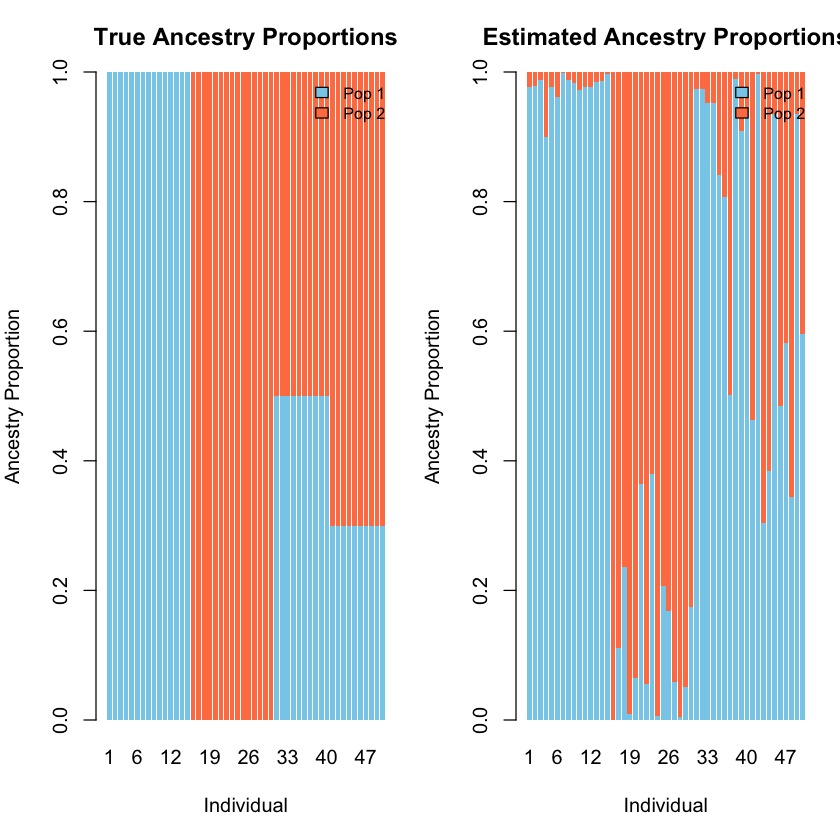

In [73]:
# Create side-by-side visualization for two populations
par(mfrow = c(1, 2), mar = c(5, 4, 3, 1))

# Plot 1: True ancestry
barplot(t(Q_true), 
        col = c("skyblue", "coral"),
        border = NA,
        main = "True Ancestry Proportions",
        xlab = "Individual",
        ylab = "Ancestry Proportion",
        ylim = c(0, 1),
        names.arg = 1:I)
legend("topright", 
       legend = c("Pop 1", "Pop 2"),
       fill = c("skyblue", "coral"),
       bty = "n", cex = 0.8)

# Plot 2: Estimated ancestry  
barplot(t(Q_est_aligned), 
        col = c("skyblue", "coral"),
        border = NA,
        main = "Estimated Ancestry Proportions",
        xlab = "Individual",
        ylab = "Ancestry Proportion",
        ylim = c(0, 1),
        names.arg = 1:I)
legend("topright", 
       legend = c("Pop 1", "Pop 2"),
       fill = c("skyblue", "coral"),
       bty = "n", cex = 0.8)

## Example 2: Exploratory Factor Analysis in Gene Expression

Suppose you measure expression levels of five genes across 100 tissue samples. You notice that some genes tend to go up or down together—but why? Could it be because they're controlled by the same underlying biological pathway? In this example, we'll explore how factor analysis helps us uncover those hidden pathways. We'll start by letting the data show us what structure exists (exploratory analysis), and then we'll test a specific theory about which genes belong to which pathways -- showing how this detective work can reveal the invisible biological forces driving patterns in your data.

First, let's create toy data with a known structure where we have two latent biological pathways affecting gene expression.

### Generate Data

In [5]:
rm(list=ls())
library(psych)
library(lavaan)
library(ggplot2)
library(reshape2)

set.seed(29)

# ============================================================
# Create toy data with known structure
# ============================================================

n_samples <- 100   # 100 tissue samples
n_genes <- 5       # 5 genes total

# Two latent factors (biological pathways)
factor1 <- rnorm(n_samples)  # Inflammatory pathway activity
factor2 <- rnorm(n_samples)  # Metabolic pathway activity

# Create gene expression data
# Genes 1-2: belong to Factor 1 (Inflammatory)
# Genes 3-5: belong to Factor 2 (Metabolic)

expression <- matrix(0, nrow = n_samples, ncol = n_genes)

for (i in 1:n_samples) {
  # Genes 1-2: high loading on Factor 1
  expression[i, 1:2] <- 0.8 * factor1[i] + rnorm(2, 0, 0.3)
  
  # Genes 3-5: high loading on Factor 2
  expression[i, 3:5] <- 0.5 * factor2[i] + rnorm(3, 0, 0.3)
}

# Name the genes
colnames(expression) <- c(paste0("IL", 1:2),      # Inflammatory genes
                          paste0("METAB", 1:3))   # Metabolic genes

cat("Data dimensions:", nrow(expression), "samples x", ncol(expression), "genes\n")
cat("\nFirst few rows of expression data:\n")
round(head(expression), 2)

Data dimensions: 100 samples x 5 genes

First few rows of expression data:


IL1,IL2,METAB1,METAB2,METAB3
-1.27,-0.67,0.15,-0.25,-0.49
-1.05,-1.05,0.14,0.67,0.00
0.50,-0.05,-1.19,-0.86,-0.50
0.84,1.34,-0.83,-1.50,-0.02
-0.82,-0.89,0.44,0.82,0.36
1.54,1.61,1.08,0.77,0.95


### Correlation Between Genes

Before applying factor analysis, let's examine the correlation matrix between the gene expressions. Notice how genes within the same pathway are highly correlated.

=== Gene-Gene Correlation Matrix ===


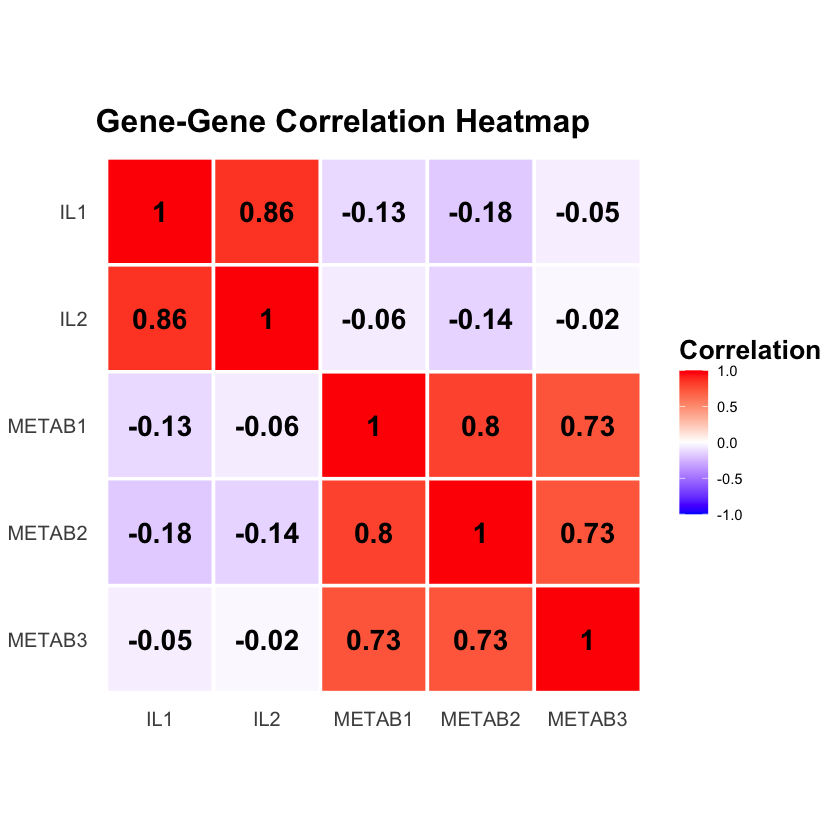

In [6]:
cat("=== Gene-Gene Correlation Matrix ===\n")
cor_matrix <- cor(expression)

# Convert correlation matrix to long format
cor_melted <- melt(cor_matrix)
colnames(cor_melted) <- c("Gene1", "Gene2", "Correlation")

# Reverse the factor order so it goes top to bottom and left to right
cor_melted$Gene1 <- factor(cor_melted$Gene1, levels = rev(colnames(cor_matrix)))
cor_melted$Gene2 <- factor(cor_melted$Gene2, levels = colnames(cor_matrix))

# Create ggplot heatmap
p_heatmap <- ggplot(cor_melted, aes(x = Gene2, y = Gene1, fill = Correlation)) +
  geom_tile(color = "white", linewidth = 1) +
  geom_text(aes(label = round(Correlation, 2)), 
            color = "black", size = 6, fontface = "bold") +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                       midpoint = 0, limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    title = element_text(size = 16, face = "bold"),
    axis.title = element_blank(),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    panel.grid = element_blank(),
    aspect.ratio = 1,
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) +
  labs(title = "Gene-Gene Correlation Heatmap",
       fill = "Correlation")


print(p_heatmap)
ggsave("./cartoons/factor_analysis.png", plot = p_heatmap, width = 12, height = 6,  
       units = "in", dpi = 300, bg = "transparent")

### Conduct EFA

EFA is appropriate when we don't know the factor structure a priori. We let the data tell us which variables load on which factors.

We first use the proportion of variance explained criterion to decide how many factors to retain. This approach selects the minimum number of factors needed to explain a specified percentage of the total variance (e.g., 80%). This method is more interpretable than the Kaiser criterion because it directly relates to how much of the data's variability we're capturing, and it allows researchers to explicitly set a variance threshold based on their domain knowledge and practical requirements.

In [7]:
cat("\n=== EFA: Determining Number of Factors ===\n\n")

# Method 1: Eigenvalues and Variance Explained
ev <- eigen(cor_matrix)$values
cat("Eigenvalues:\n")
print(round(ev, 3))

# Calculate cumulative proportion of variance explained
variance_explained <- ev / sum(ev) * 100
cumulative_variance <- cumsum(variance_explained)

# Method: Determine factors based on cumulative variance threshold (e.g., 80%)
variance_threshold <- 80
n_factors_needed <- min(which(cumulative_variance >= variance_threshold))
cat(sprintf("\nNumber of factors needed to explain >= %d%% of variance: %d\n", 
            variance_threshold, n_factors_needed))



=== EFA: Determining Number of Factors ===



Eigenvalues:
[1] 2.589 1.786 0.286 0.201 0.138

Number of factors needed to explain >= 80% of variance: 2


Here we use the `fa` function in package `psych` to conduct factor analysis directly allowing for rotations of data points. Rotation makes the factors more interpretable by creating a simpler structure where each variable loads highly on few factors.

In [8]:
fa_efa <- fa(expression, nfactors = 2, rotate = "varimax", fm = "ml")

cat("\n=== EFA: ROTATED Factor Loadings (Varimax) ===\n")
fa_efa$loadings

# Examine communalities
cat("\n=== Communalities (variance explained by factors) ===\n")
print(round(fa_efa$communality, 3))


=== EFA: ROTATED Factor Loadings (Varimax) ===



Loadings:
       ML2    ML1   
IL1            0.895
IL2            0.957
METAB1  0.894       
METAB2  0.886 -0.133
METAB3  0.820       

                 ML2   ML1
SS loadings    2.261 1.737
Proportion Var 0.452 0.347
Cumulative Var 0.452 0.800


=== Communalities (variance explained by factors) ===
   IL1    IL2 METAB1 METAB2 METAB3 
 0.806  0.916  0.802  0.802  0.672 


#### Evaluate EFA Results

Factor scores represent the estimated values of the latent factors for each sample, and can be used in downstream analyses.


=== EFA Factor Scores (first 5 samples) ===
These represent pathway activity in each sample:



ML2,ML1
-0.287,-0.847
0.420,-1.090
-1.413,0.213
-1.300,1.528
0.836,-0.869



=== How Well Did EFA Recover the True Factors? ===
Factor 1 (Inflammatory) correlation: 0.955 
Factor 2 (Metabolic) correlation:    0.948 


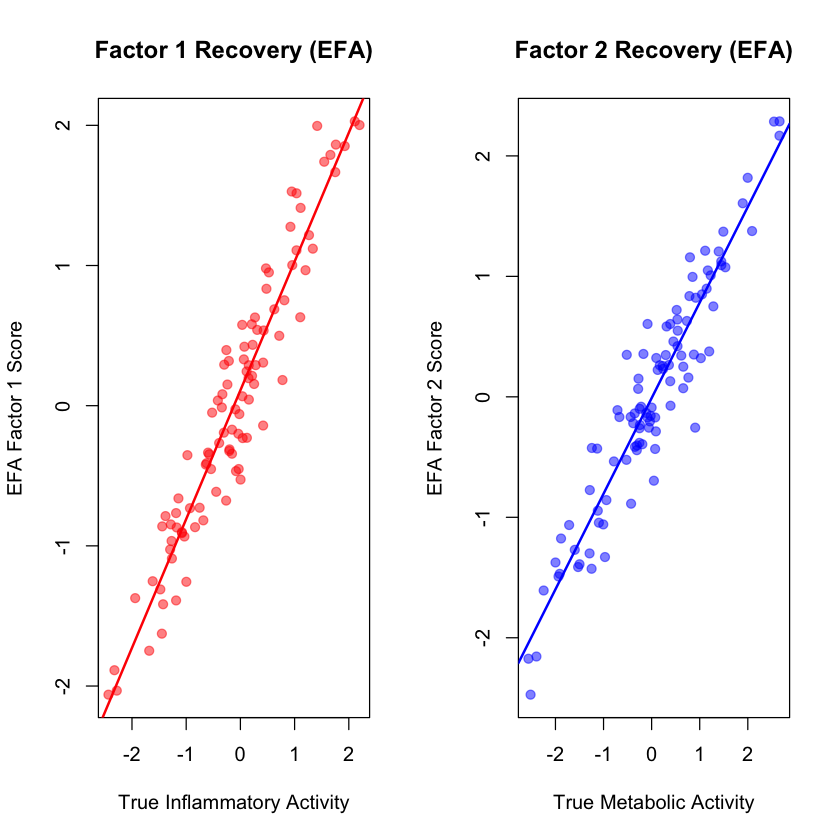

In [9]:
# Extract factor scores
factor_scores_efa <- fa_efa$scores

cat("\n=== EFA Factor Scores (first 5 samples) ===\n")
cat("These represent pathway activity in each sample:\n\n")
round(head(factor_scores_efa, 5), 3)

# How well did we recover the true factors?
cat("\n=== How Well Did EFA Recover the True Factors? ===\n")
cat("Factor 1 (Inflammatory) correlation:", round(abs(cor(factor1, factor_scores_efa[,2])), 3), "\n")
cat("Factor 2 (Metabolic) correlation:   ", round(abs(cor(factor2, factor_scores_efa[,1])), 3), "\n")

# Visualize the recovered factors
par(mfrow = c(1, 2))

plot(factor1, factor_scores_efa[,2],
     xlab = "True Inflammatory Activity",
     ylab = "EFA Factor 1 Score",
     main = "Factor 1 Recovery (EFA)",
     pch = 19, col = rgb(1, 0, 0, 0.5))
abline(lm(factor_scores_efa[,2] ~ factor1), col = "red", lwd = 2)

plot(factor2, factor_scores_efa[,1],
     xlab = "True Metabolic Activity",
     ylab = "EFA Factor 2 Score",
     main = "Factor 2 Recovery (EFA)",
     pch = 19, col = rgb(0, 0, 1, 0.5))
abline(lm(factor_scores_efa[,1] ~ factor2), col = "blue", lwd = 2)

# Extended Reading

- [Introduction to Probabilistic Topic Models](https://www.cs.columbia.edu/~blei/papers/Blei2012.pdf). DB Blei (2012). Communications of the ACM. 55 (4): 77-84.